In [1]:
# %load SheetShelfCalving_H_bed.py
import sys
import os
import tensorflow as tf
import numpy as np
sys.path.append(".")
sys.path.append("./utils")
from custom_lbfgs import *
from SSAutil import *
from neuralnetwork import NeuralNetwork
from logger import Logger
from plotting import *
import matplotlib.pyplot as plt

# Manually making sure the numpy random seeds are "the same" on all devices
np.random.seed(1234)
tf.random.set_seed(1234)

In [2]:
# Hyper parameters {{{
hp = {}
# Data size on the solution u
hp["N_u"] = 2000
# Collocation points size, where we’ll check for f = 0
hp["N_f"] = 3000
# DeepNN topology (2-sized input [x t], 8 hidden layer of 20-width, 1-sized output [u]
hp["layers"] = [2, 20, 20, 20, 20, 20, 20, 20, 20, 2]
# Setting up the TF SGD-based optimizer (set tf_epochs=0 to cancel it)
hp["tf_epochs"] = 100000
hp["tf_lr"] = 0.001
hp["tf_b1"] = 0.99
hp["tf_eps"] = 1e-1
# Setting up the quasi-newton LBGFS optimizer (set nt_epochs=0 to cancel it)
hp["nt_epochs"] = 0
hp["nt_lr"] = 1.2
hp["nt_ncorr"] = 50
hp["log_frequency"] = 1000
hp["use_tfp"] = False
# Record the history
hp["save_history"] = True
# path for loading data and saving models
repoPath = "./"
appDataPath = os.path.join(repoPath, "matlab_SSA", "DATA")
path = os.path.join(appDataPath, "SSA2D_circleF.mat")
modelPath = "./Models/SheetCircleF_H_bed"
reloadModel = False # reload from previous training
#}}}

In [3]:
class HBedDNN(NeuralNetwork): #{{{
    def __init__(self, hp, logger, X_f, xub, xlb, uub, ulb, modelPath="./", reloadModel=False):
        super().__init__(hp, logger, xub, xlb, uub, ulb, modelPath, reloadModel)

        # scaling factors
        self.ub = xub
        self.lb = xlb

        # Separating the collocation coordinates
        self.x_f = self.tensor(X_f[:, 0:1])
        self.y_f = self.tensor(X_f[:, 1:2])

    @tf.function
    def gradient_model(self):
        with tf.GradientTape(persistent=True) as tape:
            tape.watch(self.x_f)
            tape.watch(self.y_f)
            Xtemp = tf.concat([self.x_f, self.y_f], axis=1)

            Hb = self.model(Xtemp)
            H = Hb[:, 0:1]
            b = Hb[:, 1:2]
            h = H + b

        h_x = tape.gradient(h, self.x_f)
        h_y = tape.gradient(h, self.y_f)
        del tape

        return h_x, h_y

    @tf.function
    def loss(self, hb, hb_pred):
        h0 = hb[:, 0:1]
        b0 = hb[:, 1:2]

        h0_pred = hb_pred[:, 0:1]
        b0_pred = hb_pred[:, 1:2]
#         h_x, h_y = self.gradient_model()

        mse_h = tf.reduce_mean(tf.square(h0 - h0_pred))
        mse_b = tf.reduce_mean(tf.square(b0 - b0_pred))
#         mse_hx = 0*1e8*tf.reduce_mean(tf.square(h_x))
#         mse_hy = 0*1e8*tf.reduce_mean(tf.square(h_y))

#        tf.print(f"mse_u {mse_u}    mse_v {mse_v}    mse_f1    {mse_f1}    mse_f2    {mse_f2}")
        return mse_h+mse_b#+mse_hx+mse_hy

    def predict(self, X_star):
        h_pred = self.model(X_star)
        u_pred = h_pred[:, 0:1]
        v_pred = h_pred[:, 1:2]
        return u_pred.numpy(), v_pred.numpy()
    
    @tf.function
    def test_error(self, X_star, u_star):
        h_pred = self.model(X_star)
        return  tf.math.reduce_euclidean_norm(h_pred - u_star[:,0:2]) / tf.math.reduce_euclidean_norm(u_star[:,0:2])
    #}}}
    

In [4]:
# Training {{{
# set the path
x, y, X_star, u_star, X_f, xub, xlb, uub, ulb = prep_Helheim_H_bed(path)
# Creating the model and training
logger = Logger(hp)
pinn = HBedDNN(hp, logger, X_f, xub, xlb, uub[0:2], ulb[0:2], modelPath)

# error function for logger
def error():
    return pinn.test_error(X_star, u_star)
logger.set_error_fn(error)

# fit the data
pinn.fit(X_star, u_star)

# save the weights
pinn.save()

# }}}

Hyperparameters:
{
  "N_u": 2000,
  "N_f": 3000,
  "layers": [
    2,
    20,
    20,
    20,
    20,
    20,
    20,
    20,
    20,
    2
  ],
  "tf_epochs": 100000,
  "tf_lr": 0.001,
  "tf_b1": 0.99,
  "tf_eps": 0.1,
  "nt_epochs": 0,
  "nt_lr": 1.2,
  "nt_ncorr": 50,
  "log_frequency": 1000,
  "use_tfp": false,
  "save_history": true
}

TensorFlow version: 2.4.1
Eager execution: True
Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.
GPU-accerelated: True

Training started
-- Starting Adam optimization --
tf_epoch =      0  elapsed = 00:02 (+02.0)  loss = 5.8696e+04  
tf_epoch =   1000  elapsed = 00:06 (+04.1)  loss = 4.8222e+01  
tf_epoch =   2000  elapsed = 00:10 (+04.2)  loss = 2.2922e+01  
tf_epoch =   3000  elapsed = 00:14 (+04.2)  loss = 3.9343e+00  
tf_epoch =   4000  elapsed = 00:18 (+04.1)  loss = 2.6644e+00  
tf_epoch =   5000  elapsed = 00:23 (+04.2)  loss = 1.8288e+00  
tf_epoch =   6000  elapsed = 00:27 (+04.2)  loss = 1.0732e+00  
tf_epoc

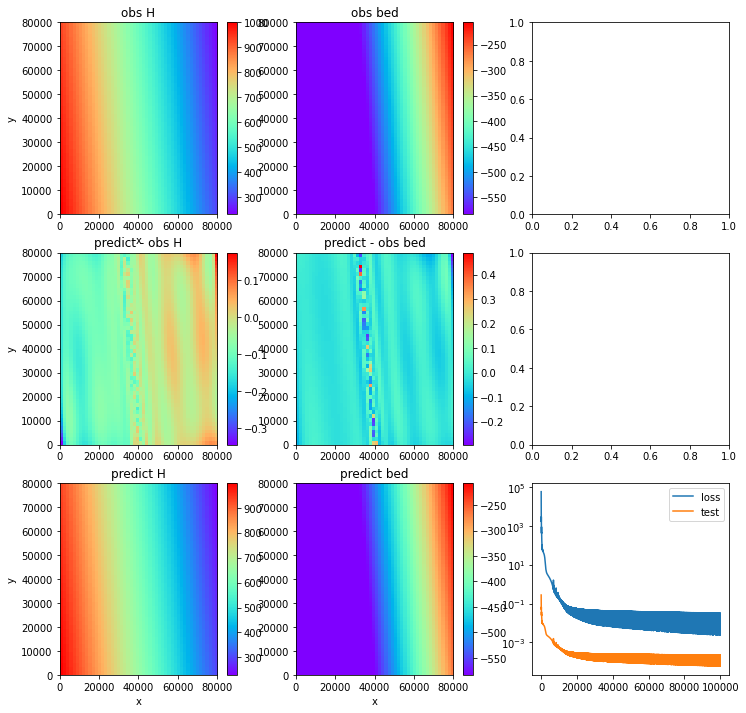

In [5]:
# plot
plot_H_bed_train(pinn, X_star, u_star, xlb, xub)

# test load
# pinn2 = HBedDNN(hp, logger, X_f, xub, xlb, uub, ulb)
# pinn2.model = tf.keras.models.load_model(modelSavePath)

# # plot
# plot_H_bed_train(pinn2, X_star, u_star, xlb, xub)